In [1]:
import logging
from transformers import logging as hf_logging

# 1. 屏蔽 Hugging Face 的特定警告
hf_logging.set_verbosity_error() 

# 2. 屏蔽 Python 标准库的警告 (如果不希望看到 deprecation warning)
import warnings
warnings.filterwarnings("ignore") 

print("已屏蔽烦人的警告信息！")


已屏蔽烦人的警告信息！


In [2]:
# 1. 安装兼容版本的 protobuf
!pip install protobuf==3.20.3

# 2. ⚠️ 重要：安装完成后，你必须重启内核 (Restart Kernel) 才能生效！
# 在 Kaggle/Colab 菜单栏选择: Run -> Restart Kernel (或 Session)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

2026-01-12 09:21:10.675005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768209670.697580     139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768209670.704147     139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🚀 运行设备: cuda

>>> [1/8] 准备数据 (使用与 CNN 一致的 Hash 划分)...
 -> 训练集 (Train): 1453
 -> 验证集 (Val):   344
 -> 测试集 (Test):  447

>>> [2/8] 绘制数据集分布饼图...


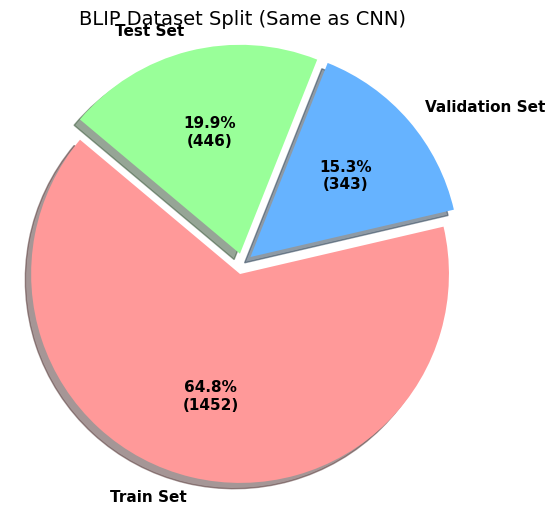


>>> [3/8] 构建答案词表...
 -> 有效答案类别数: 365

>>> [4/8] 开始训练...
Epoch 01 | Train: 4.1705 | Val: 2.9891 | Acc: 33.06% (Closed: 46.1%, Open: 0.0%)
         -> 🌟 New Best Model Saved!
Epoch 02 | Train: 3.5493 | Val: 2.3570 | Acc: 44.35% (Closed: 58.4%, Open: 8.6%)
         -> 🌟 New Best Model Saved!
Epoch 03 | Train: 3.2377 | Val: 2.2733 | Acc: 42.74% (Closed: 55.6%, Open: 10.0%)
         -> 🌟 New Best Model Saved!
Epoch 04 | Train: 3.1231 | Val: 2.2317 | Acc: 40.73% (Closed: 52.8%, Open: 10.0%)
         -> 🌟 New Best Model Saved!
Epoch 05 | Train: 2.9780 | Val: 2.2088 | Acc: 40.73% (Closed: 52.8%, Open: 10.0%)
         -> 🌟 New Best Model Saved!
Epoch 06 | Train: 2.8980 | Val: 2.2442 | Acc: 42.74% (Closed: 55.6%, Open: 10.0%)
Epoch 07 | Train: 2.8045 | Val: 2.1892 | Acc: 42.74% (Closed: 55.1%, Open: 11.4%)
         -> 🌟 New Best Model Saved!
Epoch 08 | Train: 2.6764 | Val: 2.1933 | Acc: 46.37% (Closed: 59.0%, Open: 14.3%)
Epoch 09 | Train: 2.5580 | Val: 2.2319 | Acc: 43.55% (Closed: 56.2%, Open

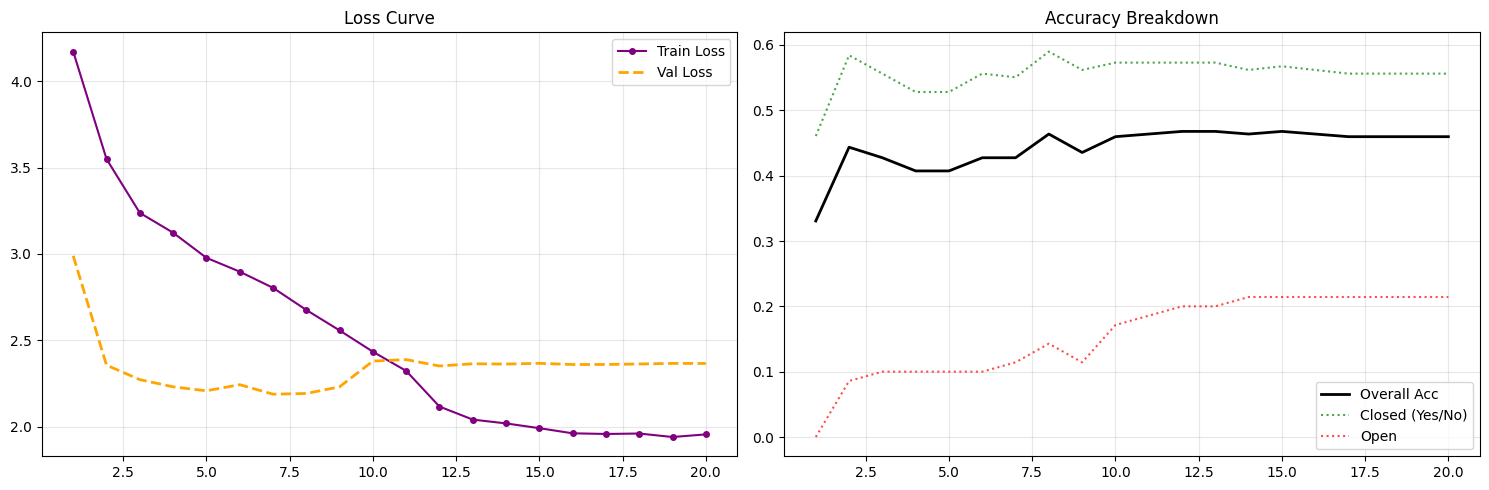


>>> [6/8] 最终测试集评估 (Best Model)...

🏆 BLIP TEST RESULTS:
Overall Acc: 56.21%
F1 Score:    0.5344
Closed Acc:  64.94%
Open Acc:    25.35%

>>> [7/8] 随机抽取 6 个测试样本可视化...


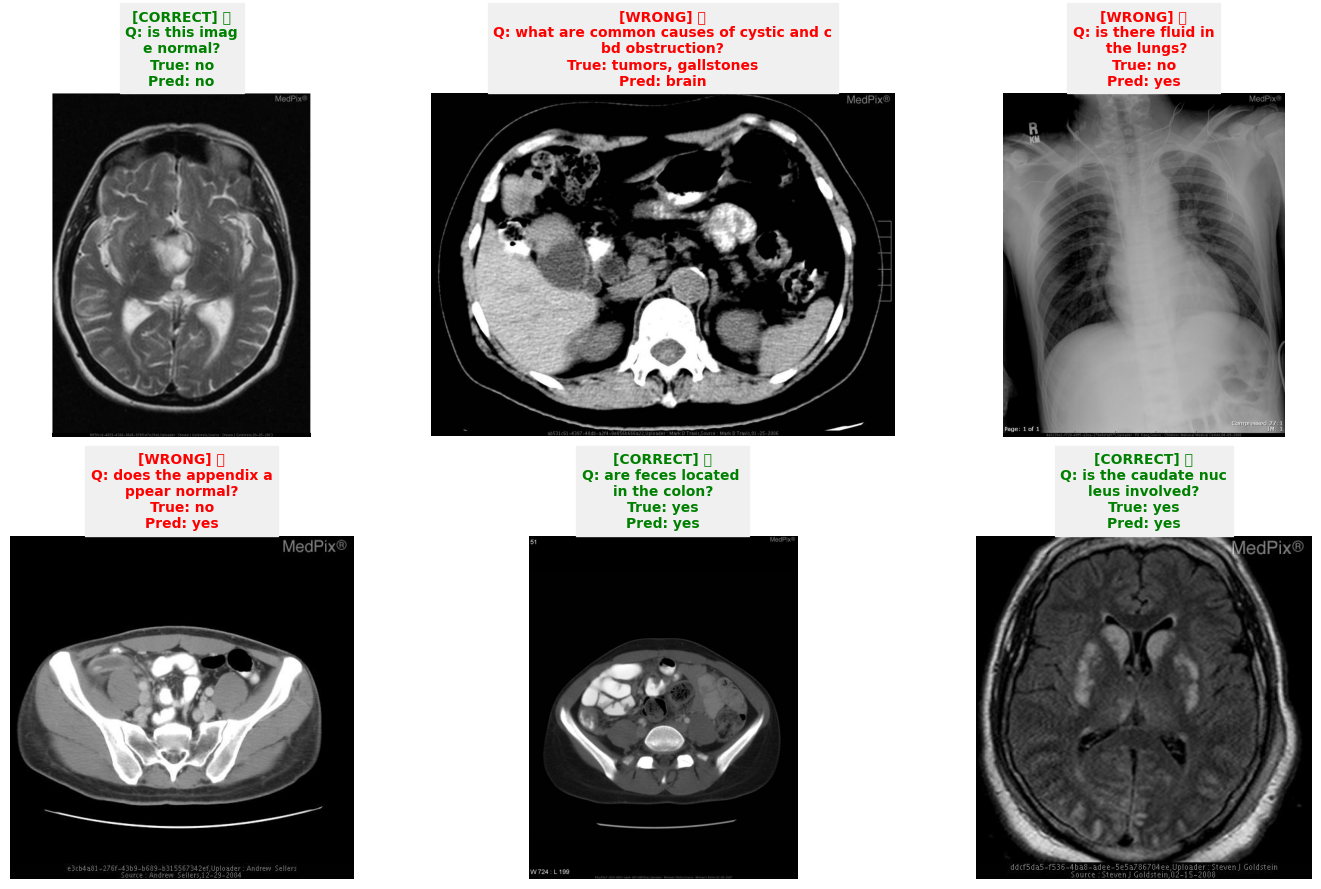


>>> [8/8] 全部执行完毕！


In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import hashlib
import time
from collections import Counter, defaultdict
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import warnings

# 忽略不必要的警告
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ================= 1. 全局配置 =================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 运行设备: {DEVICE}")

# 配置参数
BATCH_SIZE = 8          # 如果显存不够，改小这个 (如 4)
EPOCHS = 20             # 微调轮数
LEARNING_RATE = 1e-5    # BLIP 需要较小的学习率
TOP_K = 1000            # 答案词表大小
SEED = 42               # 🔥 关键：固定种子，确保和 CNN 代码划分一致
SAVE_DIR = "./output_blip_final"
BEST_MODEL_PATH = f"{SAVE_DIR}/best_blip_model.pt"

os.makedirs(SAVE_DIR, exist_ok=True)

# 🔒 锁定随机种子 (上帝模式)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# ================= 2. 数据处理 (核心：Hash 互斥划分) =================
print("\n>>> [1/8] 准备数据 (使用与 CNN 一致的 Hash 划分)...")
dataset_raw = load_dataset("flaviagiammarino/vqa-rad")
full_list = list(dataset_raw['train']) + list(dataset_raw['test'])

def get_image_hash(image):
    """计算图片的唯一 Hash 指纹"""
    return hashlib.md5(image.tobytes()).hexdigest()

def group_and_split_dataset(raw_data_list):
    """
    逻辑与 CNN 代码完全一致：
    1. 按图片 Hash 分组
    2. 使用 Seed=42 打乱
    3. 按比例切分 Train/Val/Test
    """
    image_to_qa = defaultdict(list)
    for item in raw_data_list:
        img_id = get_image_hash(item['image'])
        image_to_qa[img_id].append(item)
    
    unique_ids = list(image_to_qa.keys())
    # 这一步 shuffle 是确定性的，因为 Seed=42
    random.shuffle(unique_ids) 
    
    # 20% Test, 15% Val
    test_cutoff = int(len(unique_ids) * 0.2)
    val_cutoff = int(len(unique_ids) * 0.15)
    
    test_ids = unique_ids[:test_cutoff]
    val_ids = unique_ids[test_cutoff : test_cutoff+val_cutoff]
    train_ids = unique_ids[test_cutoff+val_cutoff:]

    def flatten(ids):
        data = []
        for i in ids: data.extend(image_to_qa[i])
        random.shuffle(data)
        return data

    return flatten(train_ids), flatten(val_ids), flatten(test_ids)

# 执行划分
train_list, val_list, test_list = group_and_split_dataset(full_list)

# 打印具体数量
print(f" -> 训练集 (Train): {len(train_list)}")
print(f" -> 验证集 (Val):   {len(val_list)}")
print(f" -> 测试集 (Test):  {len(test_list)}")

# ================= 3. 绘制数据集饼图 (与 CNN 一致) =================
print("\n>>> [2/8] 绘制数据集分布饼图...")

def plot_data_distribution(train, val, test):
    labels = ['Train Set', 'Validation Set', 'Test Set']
    sizes = [len(train), len(val), len(test)]
    colors = ['#ff9999', '#66b3ff', '#99ff99'] 
    explode = (0.05, 0.05, 0.05) 

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, explode=explode, 
            autopct=lambda p: '{:.1f}%\n({:d})'.format(p, int(p/100.*sum(sizes))), 
            shadow=True, startangle=140, textprops={'fontsize': 11, 'weight': 'bold'})
    plt.title('BLIP Dataset Split (Same as CNN)', fontsize=14)
    plt.axis('equal')
    plt.show()

plot_data_distribution(train_list, val_list, test_list)

# ================= 4. 构建词表 (仅基于训练集) =================
print("\n>>> [3/8] 构建答案词表...")
# ⚠️ 严防数据泄露：只用 train_list 里的答案
all_train_answers = [str(item['answer']).lower() for item in train_list]
answer_counts = Counter(all_train_answers)
top_answers = [ans for ans, count in answer_counts.most_common(TOP_K)]

answer2id = {ans: i for i, ans in enumerate(top_answers)}
id2answer = {i: ans for i, ans in enumerate(top_answers)}
NUM_LABELS = len(top_answers)
print(f" -> 有效答案类别数: {NUM_LABELS}")

# ================= 5. Dataset 与 Processor =================
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

class VQADataset(Dataset):
    def __init__(self, data_list, processor, answer2id):
        self.data = data_list
        self.processor = processor
        self.answer2id = answer2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image'].convert('RGB')
        question = item['question']
        answer = str(item['answer']).lower()
        
        # BLIP 处理器
        encoding = self.processor(
            images=image, 
            text=question, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        )
        
        label = self.answer2id.get(answer, -1) 
        # 标记问题类型 (1=Closed, 0=Open)
        type_flag = 1 if answer in ['yes', 'no'] else 0
        
        return {
            "input_ids": encoding.input_ids.squeeze(),
            "pixel_values": encoding.pixel_values.squeeze(),
            "attention_mask": encoding.attention_mask.squeeze(),
            "labels": torch.tensor(label, dtype=torch.long),
            "type_flag": torch.tensor(type_flag, dtype=torch.long)
        }

train_loader = DataLoader(VQADataset(train_list, processor, answer2id), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(VQADataset(val_list, processor, answer2id), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(VQADataset(test_list, processor, answer2id), batch_size=BATCH_SIZE, shuffle=False)

# ================= 6. 模型定义 (BLIP) =================
class BLIP_VQA_Classifier(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        self.blip = BlipModel.from_pretrained("Salesforce/blip-vqa-base")
        
        # 冻结视觉编码器 (Vision Encoder)
        for param in self.blip.vision_model.parameters():
            param.requires_grad = False
            
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(self.blip.config.text_config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(512, num_answers)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.blip(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        # 取 [CLS] token
        pooled_output = outputs.text_model_output.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)
        return logits

model = BLIP_VQA_Classifier(num_answers=NUM_LABELS).to(DEVICE)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

# ================= 7. 训练循环 =================
print("\n>>> [4/8] 开始训练...")
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'closed_acc': [], 'open_acc': []}
best_val_loss = float('inf')

start_time = time.time()

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        pixel_values = batch["pixel_values"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        
        valid = labels != -1
        if not valid.any(): continue
        
        optimizer.zero_grad()
        logits = model(pixel_values[valid], input_ids[valid], attention_mask[valid])
        loss = criterion(logits, labels[valid])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # --- Validation ---
    model.eval()
    val_loss = 0
    all_preds, all_labels, all_types = [], [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            pixel_values = batch["pixel_values"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            types = batch["type_flag"].to(DEVICE)
            
            valid = labels != -1
            if not valid.any(): continue
            
            logits = model(pixel_values[valid], input_ids[valid], attention_mask[valid])
            loss = criterion(logits, labels[valid])
            val_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels[valid].cpu().numpy())
            all_types.extend(types[valid].cpu().numpy())
            
    # Metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_types = np.array(all_types)
    
    val_acc = accuracy_score(all_labels, all_preds)
    
    # Open vs Closed
    closed_mask = (all_types == 1)
    acc_closed = accuracy_score(all_labels[closed_mask], all_preds[closed_mask]) if closed_mask.any() else 0
    acc_open = accuracy_score(all_labels[~closed_mask], all_preds[~closed_mask]) if (~closed_mask).any() else 0
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['closed_acc'].append(acc_closed)
    history['open_acc'].append(acc_open)
    
    print(f"Epoch {epoch+1:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | Acc: {val_acc:.2%} (Closed: {acc_closed:.1%}, Open: {acc_open:.1%})")
    
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("         -> 🌟 New Best Model Saved!")

print(f"✅ 训练结束，耗时 {(time.time()-start_time)/60:.1f} 分钟")

# ================= 8. 绘制 Loss 和 Accuracy 曲线 =================
print("\n>>> [5/8] 绘制训练曲线...")
def plot_metrics(hist):
    epochs = range(1, len(hist['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(epochs, hist['train_loss'], label='Train Loss', color='purple', marker='o', markersize=4)
    ax1.plot(epochs, hist['val_loss'], label='Val Loss', color='orange', linestyle='--', linewidth=2)
    ax1.set_title('Loss Curve')
    ax1.legend(); ax1.grid(True, alpha=0.3)
    
    # Accuracy Breakdown
    ax2.plot(epochs, hist['val_acc'], label='Overall Acc', color='black', linewidth=2)
    ax2.plot(epochs, hist['closed_acc'], label='Closed (Yes/No)', color='green', linestyle=':', alpha=0.7)
    ax2.plot(epochs, hist['open_acc'], label='Open', color='red', linestyle=':', alpha=0.7)
    ax2.set_title('Accuracy Breakdown')
    ax2.legend(); ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_metrics(history)

# ================= 9. 最终测试集评估 =================
print("\n>>> [6/8] 最终测试集评估 (Best Model)...")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

all_preds, all_labels, all_types = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        pixel_values = batch["pixel_values"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        types = batch["type_flag"].to(DEVICE)
        
        valid = labels != -1
        if not valid.any(): continue
        
        logits = model(pixel_values[valid], input_ids[valid], attention_mask[valid])
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels[valid].cpu().numpy())
        all_types.extend(types[valid].cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_types = np.array(all_types)

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
closed_mask = (all_types == 1)
closed_acc = accuracy_score(all_labels[closed_mask], all_preds[closed_mask])
open_acc = accuracy_score(all_labels[~closed_mask], all_preds[~closed_mask])

print(f"\n🏆 BLIP TEST RESULTS:")
print(f"Overall Acc: {acc:.2%}")
print(f"F1 Score:    {f1:.4f}")
print(f"Closed Acc:  {closed_acc:.2%}")
print(f"Open Acc:    {open_acc:.2%}")

# ================= 10. 随机样本可视化 =================
print("\n>>> [7/8] 随机抽取 6 个测试样本可视化...")

# 🔥 使用时间种子，确保如果你多次运行这一块，能看到不同的图
random.seed(time.time()) 

def visualize_test_samples(data_list, model, num_samples=6):
    model.eval()
    indices = random.sample(range(len(data_list)), num_samples)
    
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        item = data_list[idx]
        raw_image = item['image'].convert('RGB')
        question = item['question']
        true_ans = str(item['answer']).lower()
        
        # 推理
        inputs = processor(images=raw_image, text=question, return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            logits = model(inputs.pixel_values, inputs.input_ids, inputs.attention_mask)
            pred_idx = torch.argmax(logits, dim=1).item()
            pred_ans = id2answer.get(pred_idx, "<unk>")
        
        # 绘图
        ax = axes[i]
        ax.imshow(raw_image)
        ax.axis('off')
        
        if pred_ans == true_ans:
            color = 'green'; tag = "[CORRECT] ✅"
        else:
            color = 'red'; tag = "[WRONG] ❌"
        
        title = f"{tag}\nQ: {question}\nTrue: {true_ans}\nPred: {pred_ans}"
        if len(title) > 40:
            mid = len(title) // 2
            title = title[:mid] + "\n" + title[mid:]
            
        ax.set_title(title, fontsize=10, color=color, fontweight='bold', backgroundcolor='#f0f0f0')

    plt.tight_layout()
    plt.show()

visualize_test_samples(test_list, model)
print("\n>>> [8/8] 全部执行完毕！")